In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

<b> Import CPTAC </b>

In [2]:
import CPTAC

Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Data...

 ******PLEASE READ******


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

# Difference in protein abundance 

In [6]:
gene = 'PIK3R1'
sigList = [];
protList = ['PIK3CA']

pcutoff = 0.05/len(protList)
#pcutoff = 1

genedf = somatic_mutations[gene].to_frame()
for protein in protList:
    if protein in proteomics.columns:
        proteindf = proteomics[protein].to_frame()
        proteindfName = protein + " protein"
        proteindf.columns = [proteindfName]
        cross = genedf.add(proteindf, fill_value=0).dropna(axis=0)
        mutated = cross.loc[cross[gene] == 1.0]
        wt = cross.loc[cross[gene] == 0.0]
        ttest = scipy.stats.ttest_ind(mutated[proteindfName], wt[proteindfName])
        if ttest[1] <= pcutoff:
            sigList.append(protein)
            print("Test for " + protein + ": ")
            print(ttest)

Test for PIK3CA: 
Ttest_indResult(statistic=-3.4392766499323155, pvalue=0.0008580917991622051)


<b> Plot the results </b>

[Text(0, 0.5, 'Proteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

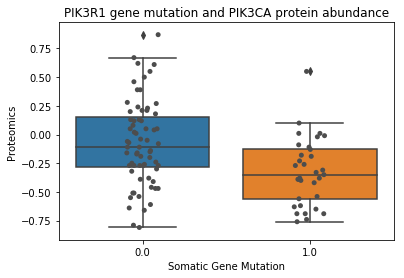

In [8]:
somatic_boxplot = sns.boxplot(data=cross, x=gene ,y=proteindfName)
somatic_boxplot.set_title(gene + " gene mutation and " + protList[0] + " protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x=gene, y=proteindfName,jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")

<b> Conclusion: PIK3CA appears to have a lower abundance when PIK3R1 is mutated </b>

# Difference in phosphoproteome abundance 

In [9]:
phosProt = phos.filter(regex='PIK3CA')
gene = 'PIK3R1'

genedf = somatic_mutations[gene].to_frame()
cross = genedf.add(phosProt, fill_value = 0)
sigResults = []
#print(cross.head())

pcutoff = 0.05/len(cross.columns)
print(pcutoff)

mutated = cross.loc[cross[gene] == 1.0]
#print(mutated.head())
wt = cross.loc[cross[gene] == 0.0]
#print(wt.head())

for loc in cross.columns:
    if not loc == gene:
        oneSitedf_m = mutated[[gene, loc]].dropna()
        oneSitedf_wt = wt[[gene, loc]].dropna()
        ttest = scipy.stats.ttest_ind(oneSitedf_m[loc], oneSitedf_wt[loc])
        sigResults.append(loc)
        print("Results for " + loc)
        print(ttest)

0.016666666666666666
Results for PIK3CA-S312
Ttest_indResult(statistic=0.11180179514314473, pvalue=0.9113951147813835)
Results for PIK3CA-T313
Ttest_indResult(statistic=-0.6796706867722941, pvalue=0.4999114450030854)


[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

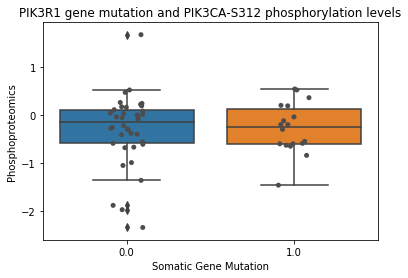

In [10]:
somatic_boxplot = sns.boxplot(data=cross, x=gene ,y=sigResults[0])
somatic_boxplot.set_title(gene + " gene mutation and " + sigResults[0] + " phosphorylation levels")
somatic_boxplot = sns.stripplot(data=cross, x=gene, y=sigResults[0],jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

<b> Conclusion: Mutations in PIK3R1 do not to appear to affect phosphoproteome abundance of PIK3CA </b>